In [2]:
import sys
import json
import h5py
import trimesh
from pathlib import Path
import argparse
import numpy as np
import trimesh.path
from shapely.geometry import Point
import matplotlib.pyplot as plt

from pytamp.utils.making_scene_utils import Make_Scene, SceneRenderer, load_mesh, load_mesh_stl, get_obj_name
from pykin.utils.mesh_utils import get_object_mesh, get_object_mesh_acronym

from acronym_tools import Scene, load_mesh, load_grasps, create_gripper_marker

import easydict

In [3]:
import sys
import json
import h5py
import trimesh
from pathlib import Path
import argparse
import numpy as np
import trimesh.path
from shapely.geometry import Point

from acronym_tools import load_grasps, create_gripper_marker
from pytamp.utils.making_scene_utils import Make_Scene, load_mesh, load_mesh_stl, get_obj_name
import easydict
from pykin.utils.mesh_utils import get_object_mesh, get_object_mesh_acronym


import os, glob 

folder_path = "/home/juju/contact_graspnet/acronym/grasps"

file_list = os.listdir(folder_path)

shelves_lst = [os.path.join(folder_path, filename) for filename in file_list if "Shelves" in filename]

folder_path = "/home/juju/contact_graspnet/acronym/grasps"

file_list = os.listdir(folder_path)

trash_lst = [os.path.join(folder_path, filename) for filename in file_list if "Trash" in filename]







In [210]:
shelves_lst[36]

'/home/juju/contact_graspnet/acronym/grasps/4Shelves_71f0db2d544b957580360680c1602c7d_0.00018128488093646088.h5'

In [4]:
def custom_parser():
    # object는 parser.add_argument( ~ , nargs="+") , nargs="+" 때문에 list로 arg 셋팅함
    args = easydict.EasyDict({
        "objects" : [
                    # "/home/juju/acronym/copied_data/grasps/Book_4698973d47c780654f48c7d5931203ac_0.01010965467789813.h5", 
                    # "/home/juju/acronym/copied_data/grasps/Bag_b914f95b191ad7c27f91c3974257b780_0.012715081291695372.h5", 
#                     "/home/juju/acronym/copied_data/grasps/Bowl_2efc35a3625fa50961a9876fa6384765_0.012449533111417973.h5"
                    '/home/juju/contact_graspnet/acronym/grasps/CerealBox_b2770011448264d330334efc12f98ae8_0.014770941563295921.h5',
                    trash_lst[7],
        ],
        # "support" : '/home/juju/contact_graspnet/acronym/grasps/3Shelves_22fbb23ca13c345b51887beb710d662a_0.0024196631371593983.h5',
        # "support" : '/home/juju/contact_graspnet/acronym/grasps/TrashBin_49bb44051ac701a38e6dba661026d53a_0.006051488061525.h5',
        "support" : shelves_lst[2], 
        "num_grasps" : 5,
        "mesh_root" : '/home/juju/contact_graspnet/acronym/',
        "support_scale" : [0.025, 0.025, 0.0175]
    })


    return args

In [106]:
args = custom_parser()

args.objects.append('ben_cube.stl')
args.objects.append('bottle.stl')
args.objects.append('bottle.stl')
# object_meshes = [load_mesh(o, mesh_root_dir=args.mesh_root) for o in args.objects]

obj_dict = {}
object_meshes=[]
object_names=[]
for o in args.objects:
    if '.h5' in o:
        object_meshes.append(load_mesh(o, mesh_root_dir=args.mesh_root))
        object_names.append(get_obj_name(obj_dict, o))
    if '.stl' in o:
        if 'cube' in o:
            object_meshes.append(get_object_mesh(o, 0.05))
            object_names.append(get_obj_name(obj_dict, o))
        else:
            object_meshes.append(get_object_mesh(o))
            object_names.append(get_obj_name(obj_dict, o))

# for PYTAMP 
support_mesh_2 = get_object_mesh("ben_table.stl", scale=[1.0, 1.5, 1.0])

# for ACRONYM
support_mesh = load_mesh(
    args.support, mesh_root_dir=args.mesh_root, scale=args.support_scale
)
scene = Make_Scene.random_arrangement(object_names,\
                                        object_meshes,\
                                        [ "table"],\
                                        [ support_mesh_2],\
                                        use_distance_limit=False,\
                                        base_mesh="table",
                                        for_goal_scene=True
                                        )

scene.colorize().as_trimesh_scene().show()



In [107]:
scene._support_objects


{'table': <trimesh.Trimesh(vertices.shape=(32, 3), faces.shape=(48, 3))>}

In [108]:
scene.get_transform("ben_cube0")

array([[ 0.2504916 , -0.96811877,  0.        , -0.13663652],
       [ 0.96811877,  0.2504916 ,  0.        ,  1.16156322],
       [ 0.        ,  0.        ,  1.        ,  0.79229998],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [109]:
target_obj = "bottle0"

support_polys, support_T , sup_obj_name= scene._get_support_polygons()
support_index = max(enumerate(support_polys), key=lambda x: x[1].area)[0]
# support_index = 7

# support_polys[support_index].centroid.x, support_polys[support_index].centroid.y 

In [127]:
table_center_xy = [support_polys[support_index].centroid.x, support_polys[support_index].centroid.y]
table_center = support_T[support_index][:3,3]
table_center_xy[1] *= -1

table_center[:2] = table_center_xy
table_center

# table_center = scene.get_transform('ben_cube0')[:3,3]

array([-0.33999999,  0.63436949,  0.76529998])

In [128]:
# support_T[support_index][:3,3]

In [137]:
renderer = SceneRenderer(scene, aspect_ratio=1.0)
trimesh_camera = renderer.get_trimesh_camera()

# custom
camera_pose = trimesh_camera.look_at(
    points=[table_center],
    rotation=trimesh.transformations.euler_matrix(
        np.pi/10,
        0,
        -np.pi/2,
    ),
#     distance=np.random.uniform(low=0.7, high=0.9),
    distance=0.5,
)
# camera_pose[2,1]
camera_pose

array([[ 6.12323400e-17,  9.51056516e-01, -3.09016994e-01,
        -4.94508490e-01],
       [-1.00000000e+00,  5.82354159e-17, -1.89218337e-17,
         6.34369494e-01],
       [-0.00000000e+00,  3.09016994e-01,  9.51056516e-01,
         1.24082823e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [138]:
# camera_pose[0,3] -= 0.17

In [139]:
# camera_pose = np.array(
#                     [
#                         [1.0, 0.0, 0.0, 0.5713422],
#                         [0.0, 0.5, -0.8660254, -0.44795896],
#                         [-0.0, 0.8660254, 0.5, 2.37007116],
#                         [0.0, 0.0, 0.0, 1.0],
#                     ]
#                 )

In [140]:
if True:
    # show scene, including a marker representing the camera
    trimesh_scene = scene.colorize({target_obj: [255, 0, 0]}).as_trimesh_scene()
    trimesh_scene.add_geometry(
        trimesh.creation.camera_marker(trimesh_camera),
        node_name="camera",
        geom_name="camera",
        transform=camera_pose.dot(
            trimesh.transformations.euler_matrix(np.pi, 0, 0)
        ),
    )
    
    pos = np.eye(4)
    pos[:3,3] = table_center
    axis = trimesh.creation.axis(origin_size=0.03, transform=pos)
    trimesh_scene.add_geometry(axis)
    trimesh_scene.show()

# render observations
color, depth, pc, segmentation = renderer.render(
    camera_pose=camera_pose, target_id=target_obj
)


# Set camera color 


In [141]:
camera_entities = len(trimesh_scene.geometry['camera_1'].entities)
camera_color = [[0,255,0] for i in range(camera_entities)]
trimesh_scene.geometry['camera_1'].colors = camera_color


# render 

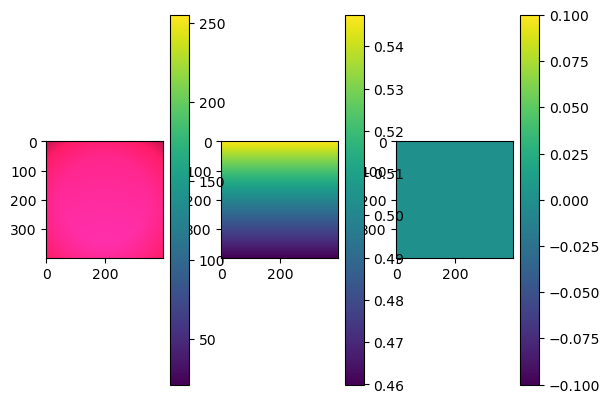

In [142]:
# plot everything except point cloud
f, axarr = plt.subplots(1, 3)
im = axarr[0].imshow(color)
f.colorbar(im, ax=axarr[0])
im = axarr[1].imshow(depth)
f.colorbar(im, ax=axarr[1])
im = axarr[2].imshow(segmentation)
f.colorbar(im, ax=axarr[2])
plt.show()


In [143]:
trimesh_scene.show()

In [144]:
camera_pose

array([[ 6.12323400e-17,  9.51056516e-01, -3.09016994e-01,
        -4.94508490e-01],
       [-1.00000000e+00,  5.82354159e-17, -1.89218337e-17,
         6.34369494e-01],
       [-0.00000000e+00,  3.09016994e-01,  9.51056516e-01,
         1.24082823e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])

In [145]:
cam_pose = np.array([[ 6.12323400e-17, -7.07106781e-01,  7.07106781e-01,
         7.20660179e-01],
       [ 1.00000000e+00,  4.32978028e-17, -4.32978028e-17,
         6.34369494e-01],
       [-0.00000000e+00,  7.07106781e-01,  7.07106781e-01,
         1.82596015e+00],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         1.00000000e+00]])